<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>



# Comparing networks

***Comparing networks: Characterizing computational similarity in task-trained recurrent neural networks***

**By Neuromatch Academy**


__Content creators:__ Chris Versteeg

__Content reviewers:__ Chris Versteeg, Hannah Choi, Eva Dyer

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

---


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Zip the entire /content folder into your Drive
#!zip -r /content/drive/MyDrive/ColabBackup/content_backup_24july.zip /content/ComputationThruDynamicsBenchmark/

  adding: content/ComputationThruDynamicsBenchmark/ (stored 0%)
  adding: content/ComputationThruDynamicsBenchmark/README.md (deflated 57%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/ (stored 0%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/README.md (deflated 56%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/LICENSE (deflated 41%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/tests/ (stored 0%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/tests/dmd_test.py (deflated 75%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/tests/simdist_test.py (deflated 73%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/tests/dsa_test.py (deflated 81%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/.git/ (stored 0%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/.git/description (deflated 14%)
  adding: content/ComputationThruDynamicsBenchmark/DSA_main/.git/refs/ (stored 0%)
  ad

In [ ]:
!unzip -q /content/drive/MyDrive/ColabBackup/content_backup_24july.zip -d /

# Helper functions

In [ ]:
# @title Helper functions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_2d_random_process(A, B, T=1000):
    """
    Generates a 2D random process with the equation x(t+1) = A.x(t) + B.noise.

    Args:
        A: 2x2 transition matrix.
        B: 2x2 noise scaling matrix.
        T: Number of time steps.

    Returns:
        A NumPy array of shape (T+1, 2) representing the trajectory.
    """
    # Assuming equilibrium distribution is zero mean and identity covariance for simplicity.
    # You may adjust this according to your actual equilibrium distribution
    x = np.zeros(2)

    trajectory = [x.copy()] # Initialize with x(0)
    for t in range(T):
      noise = np.random.normal(size=2)  # Standard normal noise
      x = np.dot(A, x) + np.dot(B, noise)
      trajectory.append(x.copy())
    return np.array(trajectory)

"""This module computes the Havok DMD model for a given dataset."""
import torch

def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either: (1) a
        2-dimensional array/tensor of shape T x N where T is the number
        of time points and N is the number of observed dimensions
        at each time point, or (2) a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    if data.shape[int(data.ndim==3)] - (n_delays - 1)*delay_interval < 1:
        raise ValueError("The number of delays is too large for the number of time points in the data!")

    # initialize the embedding
    if data.ndim == 3:
        embedding = torch.zeros((data.shape[0], data.shape[1] - (n_delays - 1)*delay_interval, data.shape[2]*n_delays)).to(device)
    else:
        embedding = torch.zeros((data.shape[0] - (n_delays - 1)*delay_interval, data.shape[1]*n_delays)).to(device)

    for d in range(n_delays):
        index = (n_delays - 1 - d)*delay_interval
        ddelay = d*delay_interval

        if data.ndim == 3:
            ddata = d*data.shape[2]
            embedding[:,:, ddata: ddata + data.shape[2]] = data[:,index:data.shape[1] - ddelay]
        else:
            ddata = d*data.shape[1]
            embedding[:, ddata:ddata + data.shape[1]] = data[index:data.shape[0] - ddelay]

    return embedding

class DMD:
    """DMD class for computing and predicting with DMD models.
    """
    def __init__(
            self,
            data,
            n_delays,
            delay_interval=1,
            rank=None,
            rank_thresh=None,
            rank_explained_variance=None,
            reduced_rank_reg=False,
            lamb=0,
            device='cpu',
            verbose=False,
            send_to_cpu=False,
            steps_ahead=1
        ):
        """
        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults
            to 1 time step.

        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used.

        rank_thresh : float
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.

        reduced_rank_reg : bool
            Determines whether to use reduced rank regression (True) or principal component regression (False)

        lamb : float
            Regularization parameter for ridge regression. Defaults to 0.

        device: string, int, or torch.device
            A string, int or torch.device object to indicate the device to torch.

        verbose: bool
            If True, print statements will be provided about the progress of the fitting procedure.

        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        steps_ahead: int
            The number of time steps ahead to predict. Defaults to 1.
        """

        self.device = device
        self._init_data(data)

        self.n_delays = n_delays
        self.delay_interval = delay_interval
        self.rank = rank
        self.rank_thresh = rank_thresh
        self.rank_explained_variance = rank_explained_variance
        self.reduced_rank_reg = reduced_rank_reg
        self.lamb = lamb
        self.verbose = verbose
        self.send_to_cpu = send_to_cpu
        self.steps_ahead = steps_ahead

        # Hankel matrix
        self.H = None

        # SVD attributes
        self.U = None
        self.S = None
        self.V = None
        self.S_mat = None
        self.S_mat_inv = None

        # DMD attributes
        self.A_v = None
        self.A_havok_dmd = None

    def _init_data(self, data):
        # check if the data is an np.ndarry - if so, convert it to Torch
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        self.data = data
        # create attributes for the data dimensions
        if self.data.ndim == 3:
            self.ntrials = self.data.shape[0]
            self.window = self.data.shape[1]
            self.n = self.data.shape[2]
        else:
            self.window = self.data.shape[0]
            self.n = self.data.shape[1]
            self.ntrials = 1

    def compute_hankel(
            self,
            data=None,
            n_delays=None,
            delay_interval=None,
        ):
        """
        Computes the Hankel matrix from the provided data.

        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include. Defaults to None - provide only if you want
            to override the value of n_delays from the init.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults
            to 1 time step. Defaults to None - provide only if you want
            to override the value of n_delays from the init.
        """
        if self.verbose:
            print("Computing Hankel matrix ...")

        # if parameters are provided, overwrite them from the init
        self.data = self.data if data is None else self._init_data(data)
        self.n_delays = self.n_delays if n_delays is None else n_delays
        self.delay_interval = self.delay_interval if delay_interval is None else delay_interval
        self.data = self.data.to(self.device)

        self.H = embed_signal_torch(self.data, self.n_delays, self.delay_interval)

        if self.verbose:
            print("Hankel matrix computed!")

    def compute_svd(self):
        """
        Computes the SVD of the Hankel matrix.
        """

        if self.verbose:
            print("Computing SVD on Hankel matrix ...")
        if self.H.ndim == 3: #flatten across trials for 3d
            H = self.H.reshape(self.H.shape[0] * self.H.shape[1], self.H.shape[2])
        else:
            H = self.H
        # compute the SVD
        U, S, Vh = torch.linalg.svd(H.T, full_matrices=False)

        # update attributes
        V = Vh.T
        self.U = U
        self.S = S
        self.V = V

        # construct the singuar value matrix and its inverse
        # dim = self.n_delays * self.n
        # s = len(S)
        # self.S_mat = torch.zeros(dim, dim,dtype=torch.float32).to(self.device)
        # self.S_mat_inv = torch.zeros(dim, dim,dtype=torch.float32).to(self.device)
        self.S_mat = torch.diag(S).to(self.device)
        self.S_mat_inv= torch.diag(1 / S).to(self.device)

        # compute explained variance
        exp_variance_inds = self.S**2 / ((self.S**2).sum())
        cumulative_explained = torch.cumsum(exp_variance_inds, 0)
        self.cumulative_explained_variance = cumulative_explained

        #make the X and Y components of the regression by staggering the hankel eigen-time delay coordinates by time
        if self.reduced_rank_reg:
            V = self.V
        else:
            V = self.V

        if self.ntrials > 1:
            if V.numel() < self.H.numel():
                raise ValueError("The dimension of the SVD of the Hankel matrix is smaller than the dimension of the Hankel matrix itself. \n \
                                 This is likely due to the number of time points being smaller than the number of dimensions. \n \
                                 Please reduce the number of delays.")

            V = V.reshape(self.H.shape)

            #first reshape back into Hankel shape, separated by trials
            newshape = (self.H.shape[0]*(self.H.shape[1]-self.steps_ahead),self.H.shape[2])
            self.Vt_minus = V[:,:-self.steps_ahead].reshape(newshape)
            self.Vt_plus = V[:,self.steps_ahead:].reshape(newshape)
        else:
            self.Vt_minus = V[:-self.steps_ahead]
            self.Vt_plus = V[self.steps_ahead:]


        if self.verbose:
            print("SVD complete!")

    def recalc_rank(self,rank,rank_thresh,rank_explained_variance):
        '''
        Parameters
        ----------
        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used. Provide only if you want to override the value from the init.

        rank_thresh : float
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None - provide only if you want
            to override the value from the init.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None -
            provide only if you want to overried the value from the init.
            '''
        # if an argument was provided, overwrite the stored rank information
        none_vars = (rank is None) + (rank_thresh is None) + (rank_explained_variance is None)
        if none_vars != 3:
            self.rank = None
            self.rank_thresh = None
            self.rank_explained_variance = None

        self.rank = self.rank if rank is None else rank
        self.rank_thresh = self.rank_thresh if rank_thresh is None else rank_thresh
        self.rank_explained_variance = self.rank_explained_variance if rank_explained_variance is None else rank_explained_variance

        none_vars = (self.rank is None) + (self.rank_thresh is None) + (self.rank_explained_variance is None)
        if none_vars < 2:
            raise ValueError("More than one value was provided between rank, rank_thresh, and rank_explained_variance. Please provide only one of these, and ensure the others are None!")
        elif none_vars == 3:
           self.rank = len(self.S)

        if self.reduced_rank_reg:
            S = self.proj_mat_S
        else:
            S = self.S

        if rank_thresh is not None:
            if S[-1] > rank_thresh:
                self.rank = len(S)
            else:
                self.rank = torch.argmax(torch.arange(len(S), 0, -1).to(self.device)*(S < rank_thresh))

        if rank_explained_variance is not None:
            self.rank = int(torch.argmax((self.cumulative_explained_variance > rank_explained_variance).type(torch.int)).cpu().numpy())

        if self.rank > self.H.shape[-1]:
            self.rank = self.H.shape[-1]

        if self.rank is None:
            if S[-1] > self.rank_thresh:
                self.rank = len(S)
            else:
                self.rank = torch.argmax(torch.arange(len(S), 0, -1).to(self.device)*(S < self.rank_thresh))

    def compute_havok_dmd(self,lamb=None):
        """
        Computes the Havok DMD matrix (Principal Component Regression)

        Parameters
        ----------
        lamb : float
            Regularization parameter for ridge regression. Defaults to 0 - provide only if you want
            to override the value of n_delays from the init.

        """
        if self.verbose:
            print("Computing least squares fits to HAVOK DMD ...")

        self.lamb = self.lamb if lamb is None else lamb

        A_v = (torch.linalg.inv(self.Vt_minus[:, :self.rank].T @ self.Vt_minus[:, :self.rank] + self.lamb*torch.eye(self.rank).to(self.device)) \
               @ self.Vt_minus[:, :self.rank].T @ self.Vt_plus[:, :self.rank]).T
        self.A_v = A_v
        self.A_havok_dmd = self.U @ self.S_mat[:self.U.shape[1], :self.rank] @ self.A_v @ self.S_mat_inv[:self.rank, :self.U.shape[1]] @ self.U.T

        if self.verbose:
            print("Least squares complete! \n")

    def compute_proj_mat(self,lamb=None):
        if self.verbose:
            print("Computing Projector Matrix for Reduced Rank Regression")

        self.lamb = self.lamb if lamb is None else lamb

        self.proj_mat = self.Vt_plus.T @ self.Vt_minus @ torch.linalg.inv(self.Vt_minus.T @ self.Vt_minus +
                                                                          self.lamb*torch.eye(self.Vt_minus.shape[1]).to(self.device)) @ \
                                                                          self.Vt_minus.T @ self.Vt_plus

        self.proj_mat_S, self.proj_mat_V = torch.linalg.eigh(self.proj_mat)
        #todo: more efficient to flip ranks (negative index) in compute_reduced_rank_regression but also less interpretable
        self.proj_mat_S = torch.flip(self.proj_mat_S, dims=(0,))
        self.proj_mat_V = torch.flip(self.proj_mat_V, dims=(1,))

        if self.verbose:
            print("Projector Matrix computed! \n")

    def compute_reduced_rank_regression(self,lamb=None):
        if self.verbose:
            print("Computing Reduced Rank Regression ...")

        self.lamb = self.lamb if lamb is None else lamb
        proj_mat = self.proj_mat_V[:,:self.rank] @ self.proj_mat_V[:,:self.rank].T
        B_ols = torch.linalg.inv(self.Vt_minus.T @ self.Vt_minus + self.lamb*torch.eye(self.Vt_minus.shape[1]).to(self.device)) @ self.Vt_minus.T @ self.Vt_plus

        self.A_v = B_ols @ proj_mat
        self.A_havok_dmd = self.U @ self.S_mat[:self.U.shape[1],:self.A_v.shape[1]] @ self.A_v.T @ self.S_mat_inv[:self.A_v.shape[0], :self.U.shape[1]] @ self.U.T


        if self.verbose:
            print("Reduced Rank Regression complete! \n")

    def fit(
            self,
            data=None,
            n_delays=None,
            delay_interval=None,
            rank=None,
            rank_thresh=None,
            rank_explained_variance=None,
            lamb=None,
            device=None,
            verbose=None,
            steps_ahead=None
        ):
        """
        Parameters
        ----------
        data : np.ndarray or torch.tensor
            The data to fit the DMD model to. Must be either: (1) a
            2-dimensional array/tensor of shape T x N where T is the number
            of time points and N is the number of observed dimensions
            at each time point, or (2) a 3-dimensional array/tensor of shape
            K x T x N where K is the number of "trials" and T and N are
            as defined above. Defaults to None - provide only if you want to
            override the value from the init.

        n_delays : int
            Parameter that controls the size of the delay embedding. Explicitly,
            the number of delays to include. Defaults to None - provide only if you want to
            override the value from the init.

        delay_interval : int
            The number of time steps between each delay in the delay embedding. Defaults to None -
            provide only if you want to override the value from the init.

        rank : int
            The rank of V in fitting HAVOK DMD - i.e., the number of columns of V to
            use to fit the DMD model. Defaults to None, in which case all columns of V
            will be used - provide only if you want to
            override the value from the init.

        rank_thresh : int
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None - provide only if you want to
            override the value from the init.

        rank_explained_variance : float
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None -
            provide only if you want to overried the value from the init.

        lamb : float
            Regularization parameter for ridge regression. Defaults to None - provide only if you want to
            override the value from the init.

        device: string or int
            A string or int to indicate the device to torch. For example, can be 'cpu' or 'cuda',
            or alternatively 0 if the intenion is to use GPU device 0. Defaults to None - provide only
            if you want to override the value from the init.

        verbose: bool
            If True, print statements will be provided about the progress of the fitting procedure.
            Defaults to None - provide only if you want to override the value from the init.

        steps_ahead: int
            The number of time steps ahead to predict. Defaults to 1.

        """
        # if parameters are provided, overwrite them from the init
        self.steps_ahead = self.steps_ahead if steps_ahead is None else steps_ahead
        self.device = self.device if device is None else device
        self.verbose = self.verbose if verbose is None else verbose

        self.compute_hankel(data, n_delays, delay_interval)
        self.compute_svd()

        if self.reduced_rank_reg:
            self.compute_proj_mat(lamb)
            self.recalc_rank(rank,rank_thresh,rank_explained_variance)
            self.compute_reduced_rank_regression(lamb)
        else:
            self.recalc_rank(rank,rank_thresh,rank_explained_variance)
            self.compute_havok_dmd(lamb)

        if self.send_to_cpu:
            self.all_to_device('cpu') #send back to the cpu to save memory

    def predict(
        self,
        test_data=None,
        reseed=None,
        full_return=False
        ):
        """
        Returns
         -------
         pred_data : torch.tensor
             The predictions generated by the HAVOK model. Of the same shape as test_data. Note that the first
             (self.n_delays - 1)*self.delay_interval + 1 time steps of the generated predictions are by construction
             identical to the test_data.

         H_test_havok_dmd : torch.tensor (Optional)
             Returned if full_return=True. The predicted Hankel matrix generated by the HAVOK model.
         H_test : torch.tensor (Optional)
             Returned if full_return=True. The true Hankel matrix
        """
        # initialize test_data
        if test_data is None:
            test_data = self.data
        if isinstance(test_data, np.ndarray):
            test_data = torch.from_numpy(test_data).to(self.device)
        ndim = test_data.ndim
        if ndim == 2:
            test_data = test_data.unsqueeze(0)
        H_test = embed_signal_torch(test_data, self.n_delays, self.delay_interval)
        steps_ahead = self.steps_ahead if self.steps_ahead is not None else 1

        if reseed is None:
            reseed = 1

        H_test_havok_dmd = torch.zeros(H_test.shape).to(self.device)
        H_test_havok_dmd[:, :steps_ahead] = H_test[:, :steps_ahead]

        A = self.A_havok_dmd.unsqueeze(0)
        for t in range(steps_ahead, H_test.shape[1]):
            if t % reseed == 0:
                H_test_havok_dmd[:, t] = (A @ H_test[:, t - steps_ahead].transpose(-2, -1)).transpose(-2, -1)
            else:
                H_test_havok_dmd[:, t] = (A @ H_test_havok_dmd[:, t - steps_ahead].transpose(-2, -1)).transpose(-2, -1)
        pred_data = torch.hstack([test_data[:, :(self.n_delays - 1)*self.delay_interval + steps_ahead], H_test_havok_dmd[:, steps_ahead:, :self.n]])

        if ndim == 2:
            pred_data = pred_data[0]

        if full_return:
            return pred_data, H_test_havok_dmd, H_test
        else:
            return pred_data

    def all_to_device(self,device='cpu'):
        for k,v in self.__dict__.items():
            if isinstance(v, torch.Tensor):
                self.__dict__[k] = v.to(device)

from typing import Literal
import torch.nn as nn
import torch.optim as optim
from typing import Literal
import torch.nn.utils.parametrize as parametrize
from scipy.stats import wasserstein_distance

def pad_zeros(A,B,device):

    with torch.no_grad():
        dim = max(A.shape[0],B.shape[0])
        A1 = torch.zeros((dim,dim)).float()
        A1[:A.shape[0],:A.shape[1]] += A
        A = A1.float().to(device)

        B1 = torch.zeros((dim,dim)).float()
        B1[:B.shape[0],:B.shape[1]] += B
        B = B1.float().to(device)

    return A,B

class LearnableSimilarityTransform(nn.Module):
    """
    Computes the similarity transform for a learnable orthonormal matrix C
    """
    def __init__(self, n,orthog=True):
        """
        Parameters
        __________
        n : int
            dimension of the C matrix
        """
        super(LearnableSimilarityTransform, self).__init__()
        #initialize orthogonal matrix as identity
        self.C = nn.Parameter(torch.eye(n).float())
        self.orthog = orthog

    def forward(self, B):
        if self.orthog:
            return self.C @ B @ self.C.transpose(-1, -2)
        else:
            return self.C @ B @ torch.linalg.inv(self.C)

class Skew(nn.Module):
    def __init__(self,n,device):
        """
        Computes a skew-symmetric matrix X from some parameters (also called X)

        """
        super().__init__()

        self.L1 = nn.Linear(n,n,bias = False, device = device)
        self.L2 = nn.Linear(n,n,bias = False, device = device)
        self.L3 = nn.Linear(n,n,bias = False, device = device)

    def forward(self, X):
        X = torch.tanh(self.L1(X))
        X = torch.tanh(self.L2(X))
        X = self.L3(X)
        return X - X.transpose(-1, -2)

class Matrix(nn.Module):
    def __init__(self,n,device):
        """
        Computes a matrix X from some parameters (also called X)

        """
        super().__init__()

        self.L1 = nn.Linear(n,n,bias = False, device = device)
        self.L2 = nn.Linear(n,n,bias = False, device = device)
        self.L3 = nn.Linear(n,n,bias = False, device = device)

    def forward(self, X):
        X = torch.tanh(self.L1(X))
        X = torch.tanh(self.L2(X))
        X = self.L3(X)
        return X

class CayleyMap(nn.Module):
    """
    Maps a skew-symmetric matrix to an orthogonal matrix in O(n)
    """
    def __init__(self, n, device):
        """
        Parameters
        __________

        n : int
            dimension of the matrix we want to map

        device : {'cpu','cuda'} or int
            hardware device on which to send the matrix
        """
        super().__init__()
        self.register_buffer("Id", torch.eye(n,device = device))

    def forward(self, X):
        # (I + X)(I - X)^{-1}
        return torch.linalg.solve(self.Id + X, self.Id - X)

class SimilarityTransformDist:
    """
    Computes the Procrustes Analysis over Vector Fields
    """
    def __init__(self,
                iters = 200,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 0.01,
                device: Literal["cpu","cuda"] = 'cpu',
                verbose = False,
                group: Literal["O(n)","SO(n)","GL(n)"] = "O(n)",
                wasserstein_compare = None
                ):
        """
        Parameters
        _________
        iters : int
            number of iterations to perform gradient descent

        score_method : {"angular","euclidean","wasserstein"}
            specifies the type of metric to use
            "wasserstein" will compare the singular values or eigenvalues
            of the two matrices as in Redman et al., (2023)

        lr : float
            learning rate

        device : {'cpu','cuda'} or int

        verbose : bool
            prints when finished optimizing

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """

        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.C_star = None
        self.A = None
        self.B = None
        self.group = group
        self.wasserstein_compare = wasserstein_compare

    def fit(self,
            A,
            B,
            iters = None,
            lr = None,
            group = None,
            ):
        """
        Computes the optimal matrix C over specified group

        Parameters
        __________
        A : np.array or torch.tensor
            first data matrix
        B : np.array or torch.tensor
            second data matrix
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        Returns
        _______
        None
        """
        assert A.shape[0] == A.shape[1]
        assert B.shape[0] == B.shape[1]

        A = A.to(self.device)
        B = B.to(self.device)
        self.A,self.B = A,B
        lr = self.lr if lr is None else lr
        iters = self.iters if iters is None else iters
        group = self.group if group is None else group

        if group in {"SO(n)", "O(n)"}:
            self.losses, self.C_star, self.sim_net = self.optimize_C(A,
                                                                     B,
                                                                     lr,iters,
                                                                     orthog=True,
                                                                     verbose=self.verbose)
        if group == "O(n)":
            #permute the first row and column of B then rerun the optimization
            P = torch.eye(B.shape[0],device=self.device)
            if P.shape[0] > 1:
                P[[0, 1], :] = P[[1, 0], :]
            losses, C_star, sim_net = self.optimize_C(A,
                                                    P @ B @ P.T,
                                                    lr,iters,
                                                    orthog=True,
                                                    verbose=self.verbose)
            if losses[-1] < self.losses[-1]:
                self.losses = losses
                self.C_star = C_star @ P
                self.sim_net = sim_net
        if group == "GL(n)":
            self.losses, self.C_star, self.sim_net = self.optimize_C(A,
                                                                B,
                                                                lr,iters,
                                                                orthog=False,
                                                                verbose=self.verbose)

    def optimize_C(self,A,B,lr,iters,orthog,verbose):
        #parameterize mapping to be orthogonal
        n = A.shape[0]
        sim_net = LearnableSimilarityTransform(n,orthog=orthog).to(self.device)
        if orthog:
            parametrize.register_parametrization(sim_net, "C", Skew(n,self.device))
            parametrize.register_parametrization(sim_net, "C", CayleyMap(n,self.device))
        else:
            parametrize.register_parametrization(sim_net, "C", Matrix(n,self.device))

        simdist_loss = nn.MSELoss(reduction = 'sum')

        optimizer = optim.Adam(sim_net.parameters(), lr=lr)
        # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

        losses = []
        A /= torch.linalg.norm(A)
        B /= torch.linalg.norm(B)
        for _ in range(iters):
            # Zero the gradients of the optimizer.
            optimizer.zero_grad()
            # Compute the Frobenius norm between A and the product.
            loss = simdist_loss(A, sim_net(B))

            loss.backward()

            optimizer.step()
            # if _ % 99:
            #     scheduler.step()
            losses.append(loss.item())

        if verbose:
            print("Finished optimizing C")

        C_star = sim_net.C.detach()
        return losses, C_star,sim_net

    def score(self,A=None,B=None,score_method=None,group=None):
        """
        Given an optimal C already computed, calculate the metric

        Parameters
        __________
        A : np.array or torch.tensor or None
            first data matrix, if None defaults to the saved matrix in fit
        B : np.array or torch.tensor or None
            second data matrix if None, defaults to the savec matrix in fit
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application
        Returns
        _______

        score : float
            similarity of the data under the similarity transform w.r.t C
        """
        assert self.C_star is not None
        A = self.A if A is None else A
        B = self.B if B is None else B
        assert A is not None
        assert B is not None
        assert A.shape == self.C_star.shape
        assert B.shape == self.C_star.shape
        score_method = self.score_method if score_method is None else score_method
        group = self.group if group is None else group
        with torch.no_grad():
            if not isinstance(A,torch.Tensor):
                A = torch.from_numpy(A).float().to(self.device)
            if not isinstance(B,torch.Tensor):
                B = torch.from_numpy(B).float().to(self.device)
            C = self.C_star.to(self.device)

        if group in {"SO(n)", "O(n)"}:
            Cinv = C.T
        elif group in {"GL(n)"}:
            Cinv = torch.linalg.inv(C)
        else:
            raise AssertionError("Need proper group name")
        if score_method == 'angular':
            num = torch.trace(A.T @ C @ B @ Cinv)
            den = torch.norm(A,p = 'fro')*torch.norm(B,p = 'fro')
            score = torch.arccos(num/den).cpu().numpy()
            if np.isnan(score): #around -1 and 1, we sometimes get NaNs due to arccos
                if num/den < 0:
                    score = np.pi
                else:
                    score = 0
        else:
            score = torch.norm(A - C @ B @ Cinv,p='fro').cpu().numpy().item() #/ A.numpy().size

        return score

    def fit_score(self,
                A,
                B,
                iters = None,
                lr = None,
                score_method = None,
                zero_pad = True,
                group = None):
        """
        for efficiency, computes the optimal matrix and returns the score

        Parameters
        __________
        A : np.array or torch.tensor
            first data matrix
        B : np.array or torch.tensor
            second data matrix
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : {'angular','euclidean'} or None
            overwrites parameter in the class
        zero_pad : bool
            if True, then the smaller matrix will be zero padded so its the same size
        Returns
        _______

        score : float
            similarity of the data under the similarity transform w.r.t C

        """
        score_method = self.score_method if score_method is None else score_method
        group = self.group if group is None else group

        if isinstance(A,np.ndarray):
            A = torch.from_numpy(A).float()
        if isinstance(B,np.ndarray):
            B = torch.from_numpy(B).float()

        assert A.shape[0] == B.shape[1] or self.wasserstein_compare is not None
        if A.shape[0] != B.shape[0]:
            if self.wasserstein_compare is None:
                raise AssertionError("Matrices must be the same size unless using wasserstein distance")
            else: #otherwise resort to L2 Wasserstein over singular or eigenvalues
                print(f"resorting to wasserstein distance over {self.wasserstein_compare}")

        if self.score_method == "wasserstein":
            assert self.wasserstein_compare in {"sv","eig"}
            if self.wasserstein_compare == "sv":
                a = torch.svd(A).S.view(-1,1)
                b = torch.svd(B).S.view(-1,1)
            elif self.wasserstein_compare == "eig":
                a = torch.linalg.eig(A).eigenvalues
                a = torch.vstack([a.real,a.imag]).T

                b = torch.linalg.eig(B).eigenvalues
                b = torch.vstack([b.real,b.imag]).T
            else:
                raise AssertionError("wasserstein_compare must be 'sv' or 'eig'")
            device = a.device
            a = a#.cpu()
            b = b#.cpu()
            M = ot.dist(a,b)#.numpy()
            a,b = torch.ones(a.shape[0])/a.shape[0],torch.ones(b.shape[0])/b.shape[0]
            a,b = a.to(device),b.to(device)

            score_star = ot.emd2(a,b,M)
            #wasserstein_distance(A.cpu().numpy(),B.cpu().numpy())

        else:

            self.fit(A, B,iters,lr,group)
            score_star = self.score(self.A,self.B,score_method=score_method,group=group)

        return score_star



class DSA:
    """
    Computes the Dynamical Similarity Analysis (DSA) for two data matrices
    """
    def __init__(self,
                X,
                Y=None,
                n_delays=1,
                delay_interval=1,
                rank=None,
                rank_thresh=None,
                rank_explained_variance = None,
                lamb = 0.0,
                send_to_cpu = True,
                iters = 1500,
                score_method: Literal["angular", "euclidean","wasserstein"] = "angular",
                lr = 5e-3,
                group: Literal["GL(n)", "O(n)", "SO(n)"] = "O(n)",
                zero_pad = False,
                device = 'cpu',
                verbose = False,
                reduced_rank_reg = False,
                kernel=None,
                num_centers=0.1,
                svd_solver='arnoldi',
                wasserstein_compare: Literal['sv','eig',None] = None
            ):
        """
        Parameters
        __________

        X : np.array or torch.tensor or list of np.arrays or torch.tensors
            first data matrix/matrices

        Y : None or np.array or torch.tensor or list of np.arrays or torch.tensors
            second data matrix/matrices.
            * If Y is None, X is compared to itself pairwise
            (must be a list)
            * If Y is a single matrix, all matrices in X are compared to Y
            * If Y is a list, all matrices in X are compared to all matrices in Y

        DMD parameters:

        n_delays : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            number of delays to use in constructing the Hankel matrix

        delay_interval : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            interval between samples taken in constructing Hankel matrix

        rank : int or list or tuple/list: (int,int), (list,list),(list,int),(int,list)
            rank of DMD matrix fit in reduced-rank regression

        rank_thresh : float or list or tuple/list: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by dictating a threshold
            of singular values to use. Explicitly, the rank of V will be the number of singular
            values greater than rank_thresh. Defaults to None.

        rank_explained_variance : float or list or tuple: (float,float), (list,list),(list,float),(float,list)
            Parameter that controls the rank of V in fitting HAVOK DMD by indicating the percentage of
            cumulative explained variance that should be explained by the columns of V. Defaults to None.

        lamb : float
            L-1 regularization parameter in DMD fit

        send_to_cpu: bool
            If True, will send all tensors in the object back to the cpu after everything is computed.
            This is implemented to prevent gpu memory overload when computing multiple DMDs.

        NOTE: for all of these above, they can be single values or lists or tuples,
            depending on the corresponding dimensions of the data
            If at least one of X and Y are lists, then if they are a single value
                it will default to the rank of all DMD matrices.
            If they are (int,int), then they will correspond to an individual dmd matrix
                OR to X and Y respectively across all matrices
            If it is (list,list), then each element will correspond to an individual
                dmd matrix indexed at the same position

        SimDist parameters:

        iters : int
            number of optimization iterations in Procrustes over vector fields

        score_method : {'angular','euclidean'}
            type of metric to compute, angular vs euclidean distance

        lr : float
            learning rate of the Procrustes over vector fields optimization

        group : {'SO(n)','O(n)', 'GL(n)'}
            specifies the group of matrices to optimize over

        zero_pad : bool
            whether or not to zero-pad if the dimensions are different

        device : 'cpu' or 'cuda' or int
            hardware to use in both DMD and PoVF

        verbose : bool
            whether or not print when sections of the analysis is completed

        wasserstein_compare : {'sv','eig',None}
            specifies whether to compare the singular values or eigenvalues
            if score_method is "wasserstein", or the shapes are different
        """
        self.X = X
        self.Y = Y
        if self.X is None and isinstance(self.Y,list):
            self.X, self.Y = self.Y, self.X #swap so code is easy

        self.check_method()
        if self.method == 'self-pairwise':
            self.data = [self.X]
        else:
            self.data = [self.X, self.Y]

        self.n_delays = self.broadcast_params(n_delays,cast=int)
        self.delay_interval = self.broadcast_params(delay_interval,cast=int)
        self.rank = self.broadcast_params(rank,cast=int)
        self.rank_thresh = self.broadcast_params(rank_thresh)
        self.rank_explained_variance = self.broadcast_params(rank_explained_variance)
        self.lamb = self.broadcast_params(lamb)
        self.send_to_cpu = send_to_cpu
        self.iters = iters
        self.score_method = score_method
        self.lr = lr
        self.device = device
        self.verbose = verbose
        self.zero_pad = zero_pad
        self.group = group
        self.reduced_rank_reg = reduced_rank_reg
        self.kernel = kernel
        self.wasserstein_compare = wasserstein_compare

        if kernel is None:
            #get a list of all DMDs here
            self.dmds = [[DMD(Xi,
                    self.n_delays[i][j],
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    rank_thresh=self.rank_thresh[i][j],
                    rank_explained_variance=self.rank_explained_variance[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    device=self.device,
                    verbose=self.verbose,
                    send_to_cpu=self.send_to_cpu) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]
        else:
             #get a list of all DMDs here
            self.dmds = [[KernelDMD(Xi,
                    self.n_delays[i][j],
                    kernel=self.kernel,
                    num_centers=num_centers,
                    delay_interval=self.delay_interval[i][j],
                    rank=self.rank[i][j],
                    reduced_rank_reg=self.reduced_rank_reg,
                    lamb=self.lamb[i][j],
                    verbose=self.verbose,
                    svd_solver=svd_solver,
                    ) for j,Xi in enumerate(dat)] for i,dat in enumerate(self.data)]

        self.simdist = SimilarityTransformDist(iters,score_method,lr,device,verbose,group,wasserstein_compare)

    def check_method(self):
        '''
        helper function to identify what type of dsa we're running
        '''
        tensor_or_np = lambda x: isinstance(x,(np.ndarray,torch.Tensor))

        if isinstance(self.X,list):
            if self.Y is None:
                self.method = 'self-pairwise'
            elif isinstance(self.Y,list):
                self.method = 'bipartite-pairwise'
            elif tensor_or_np(self.Y):
                self.method = 'list-to-one'
                self.Y = [self.Y] #wrap in a list for iteration
            else:
                raise ValueError('unknown type of Y')
        elif tensor_or_np(self.X):
            self.X = [self.X]
            if self.Y is None:
                raise ValueError('only one element provided')
            elif isinstance(self.Y,list):
                self.method = 'one-to-list'
            elif tensor_or_np(self.Y):
                self.method = 'default'
                self.Y = [self.Y]
            else:
                raise ValueError('unknown type of Y')
        else:
            raise ValueError('unknown type of X')

    def broadcast_params(self,param,cast=None):
        '''
        aligns the dimensionality of the parameters with the data so it's one-to-one
        '''
        out = []
        if isinstance(param,(int,float,np.integer)) or param is None: #self.X has already been mapped to [self.X]
            out.append([param] * len(self.X))
            if self.Y is not None:
                out.append([param] * len(self.Y))
        elif isinstance(param,(tuple,list,np.ndarray)):
            if self.method == 'self-pairwise' and len(param) >= len(self.X):
                out = [param]
            else:
                assert len(param) <= 2 #only 2 elements max

                #if the inner terms are singly valued, we broadcast, otherwise needs to be the same dimensions
                for i,data in enumerate([self.X,self.Y]):
                    if data is None:
                        continue
                    if isinstance(param[i],(int,float)):
                        out.append([param[i]] * len(data))
                    elif isinstance(param[i],(list,np.ndarray,tuple)):
                        assert len(param[i]) >= len(data)
                        out.append(param[i][:len(data)])
        else:
            raise ValueError("unknown type entered for parameter")

        if cast is not None and param is not None:
            out = [[cast(x) for x in dat] for dat in out]

        return out

    def fit_dmds(self,
                 X=None,
                 Y=None,
                 n_delays=None,
                 delay_interval=None,
                 rank=None,
                 rank_thresh = None,
                 rank_explained_variance=None,
                 reduced_rank_reg=None,
                 lamb = None,
                 device='cpu',
                 verbose=False,
                 send_to_cpu=True
                ):
        """
        Recomputes only the DMDs with a single set of hyperparameters. This will not compare, that will need to be done with the full procedure
        """
        X = self.X if X is None else X
        Y = self.Y if Y is None else Y
        n_delays = self.n_delays if n_delays is None else n_delays
        delay_interval = self.delay_interval if delay_interval is None else delay_interval
        rank = self.rank if rank is None else rank
        lamb = self.lamb if lamb is None else lamb
        data = []
        if isinstance(X,list):
            data.append(X)
        else:
            data.append([X])
        if Y is not None:
            if isinstance(Y,list):
                data.append(Y)
            else:
                data.append([Y])

        dmds = [[DMD(Xi,n_delays,delay_interval,
                     rank,rank_thresh,rank_explained_variance,reduced_rank_reg,
                     lamb,device,verbose,send_to_cpu) for Xi in dat] for dat in data]

        for dmd_sets in dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return dmds

    def fit_score(self):
        """
        Standard fitting function for both DMDs and PoVF

        Parameters
        __________

        Returns
        _______

        sims : np.array
            data matrix of the similarity scores between the specific sets of data
        """
        for dmd_sets in self.dmds:
            for dmd in dmd_sets:
                dmd.fit()

        return self.score()

    def score(self,iters=None,lr=None,score_method=None):
        """
        Rescore DSA with precomputed dmds if you want to try again

        Parameters
        __________
        iters : int or None
            number of optimization steps, if None then resorts to saved self.iters
        lr : float or None
            learning rate, if None then resorts to saved self.lr
        score_method : None or {'angular','euclidean'}
            overwrites the score method in the object for this application

        Returns
        ________
        score : float
            similarity score of the two precomputed DMDs
        """

        iters = self.iters if iters is None else iters
        lr = self.lr if lr is None else lr
        score_method = self.score_method if score_method is None else score_method

        ind2 = 1 - int(self.method == 'self-pairwise')
        # 0 if self.pairwise (want to compare the set to itself)

        self.sims = np.zeros((len(self.dmds[0]),len(self.dmds[ind2])))
        for i,dmd1 in enumerate(self.dmds[0]):
            for j,dmd2 in enumerate(self.dmds[ind2]):
                if self.method == 'self-pairwise':
                    if j >= i:
                        continue
                if self.verbose:
                    print(f'computing similarity between DMDs {i} and {j}')

                self.sims[i,j] = self.simdist.fit_score(dmd1.A_v,dmd2.A_v,iters,lr,score_method,zero_pad=self.zero_pad)

                if self.method == 'self-pairwise':
                    self.sims[j,i] = self.sims[i,j]


        if self.method == 'default':
            return self.sims[0,0]

        return self.sims

# Background

In [ ]:
# @markdown Colab // Kaggle installation (Part 1)

# ! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark
# %cd ComputationThruDynamicsBenchmark
# ! pip install -e .

## RUN THIS CELL, THEN RESTART SESSION AS PROMPTED (BUTTON AT BOTTOM OF THIS CELL'S FINISHED OUTPUT). DO NOT NEED TO RUN AGAIN
## PLEASE RESTART THE ENVIRONMENT FOR KAGGLE MANUALLY (Run > Restart & clear cell outputs)

In [ ]:
# @markdown Colab // Kaggle installation (Part 2)

!pip uninstall -y torchaudio torchvision

In [ ]:
# @markdown Colab // Kaggle installation (Part 3)

## GET BACK TO THE DIRECTORY AND CONFIGURE .env

################ COLAB #####################

# %cd /content/ComputationThruDynamicsBenchmark/
# envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
# #Don't change these
# TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
# EVAL_TARGET_FILE=eval_target.h5
# """

#############################################

################ KAGGLE #####################

# %cd /kaggle/working/ComputationThruDynamicsBenchmark/
# envStr = """HOME_DIR=/kaggle/working/ComputationThruDynamicsBenchmark/
# #Don't change these
# TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
# EVAL_TARGET_FILE=eval_target.h5
# """

##############################################

################ COLAB // KAGGLE #####################

# with open('.env','w') as f:
#   f.write(envStr)

##############################################

**NODE CUDA**

In [ ]:
%cd ComputationThruDynamicsBenchmark/

/content/ComputationThruDynamicsBenchmark


In [ ]:
from ctd.task_modeling.model.node import NODE
class NODE_CUDA(NODE):
    def forward(self, inputs, hidden):
        if hidden is None:
            hidden = torch.zeros((inputs.shape[0], self.latent_size),
                                 device=inputs.device)
        else:
            hidden = hidden.to(inputs.device)
        hidden = self.generator(inputs, hidden)
        output = self.readout(hidden)
        return output, hidden

In [ ]:
# @markdown Colab // Kaggle installation (Part 4)

# !git clone https://github.com/mitchellostrow/DSA
# %cd DSA/
# !pip install -e .

In [ ]:
%pip install dotenv

%pip install motornet

%pip install pytorch_lightning

%pip install POT
%pip install kooplearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s 

In [ ]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

/content/ComputationThruDynamicsBenchmark/


---
## Section 3: Three-Bit Flip-Flop task (3BFF)

We're going to start out with the task that launched a thousand Nature papers, the 3-Bit Flip-Flop. [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/) used the three-bit flip-flop in their seminal attempts to understand how dynamics can give rise to computation!


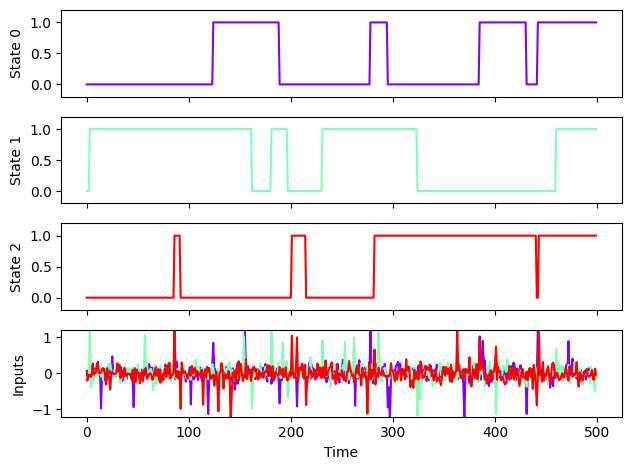

In [ ]:
from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3 # The number of bits in the flip-flop (default: 3)
trial_length = 500 # The number of time steps in each trial (default: 500)
switch_prob = 0.015 # The probability of an input pulse (default: 0.015 pulses/channel / time step)
noise = 0.15 # The standard deviation of the Gaussian noise added to the input (default: 0.15)

# This line creates the NBitFlipFlop environment. See ctd.task_modeling.task_env.task_env.NBitFlipFlop for more information.
env_3bff = NBitFlipFlop(
    n = n,
    n_timesteps=trial_length,
    switch_prob=switch_prob,
    noise=noise
    )

# Renders a random trial from the environment
env_3bff.render()

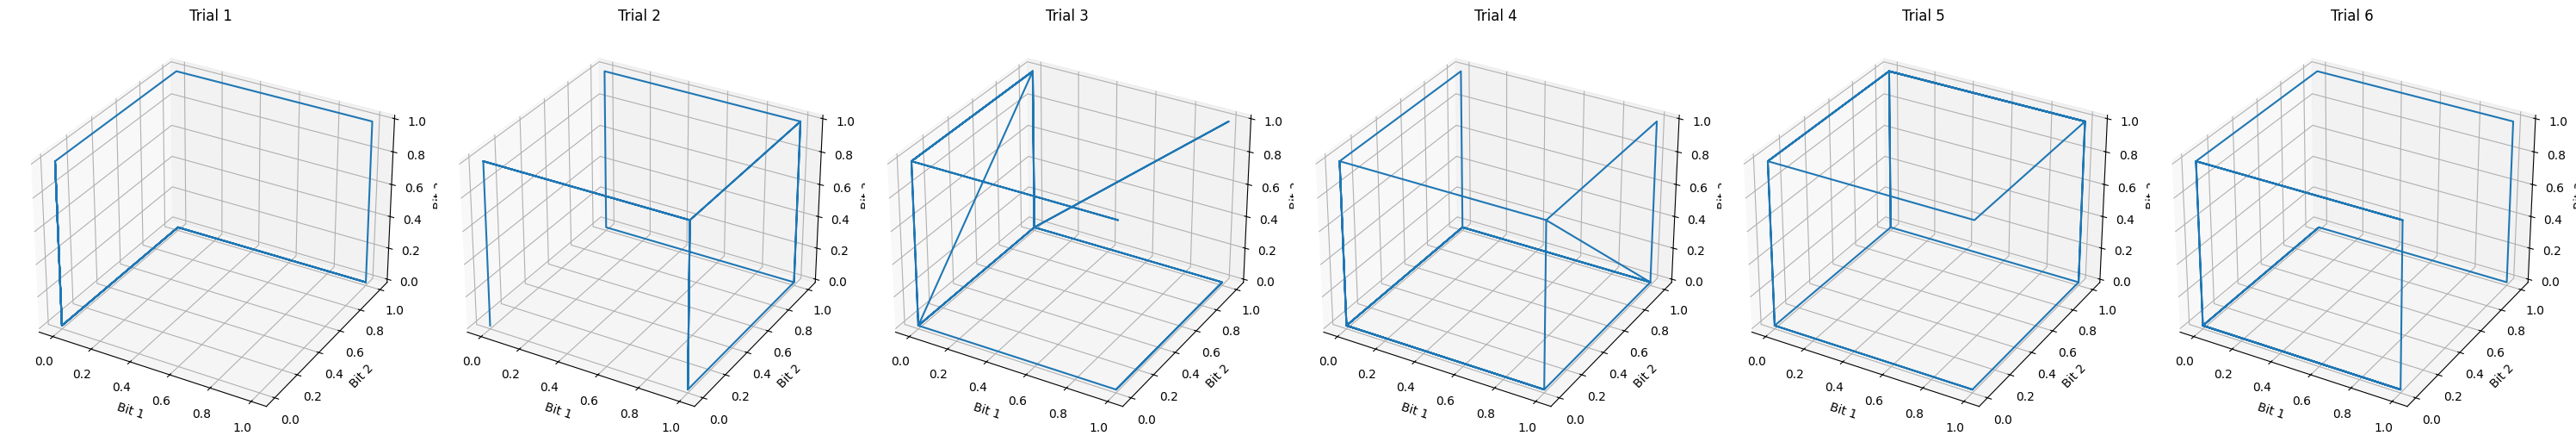

In [ ]:
env_3bff.render_3d(n_trials=6)

In [ ]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer
import pickle

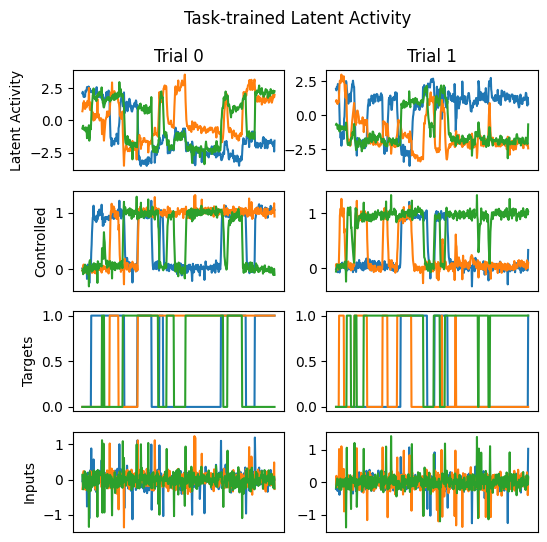

In [ ]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

fpath_GRU_128 = HOME_DIR + "models_GRU_128/"
# Create the analysis object:
analysis_GRU_128 = Analysis_TT(
    run_name = "GRU_128_3bff",
    filepath = fpath_GRU_128)

analysis_GRU_128.plot_trial_io(num_trials = 2)

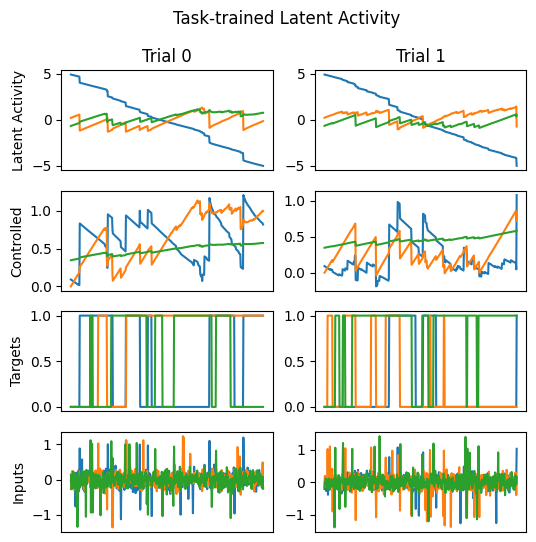

In [ ]:
from ctd.task_modeling.model.node import NODE
fpath_NODE = HOME_DIR + "models_NODE_3/"
# Create the analysis object:
analysis_NODE = Analysis_TT(
    run_name = "NODE_3_3bff",
    filepath = fpath_NODE)

analysis_NODE.plot_trial_io(num_trials = 2)

In [ ]:
#GRU
print("GRU")

print(f"All data shape: {analysis_GRU_128.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128.get_latents(phase = 'val').shape}")

#NODE
print("NODE")
print(f"All data shape: {analysis_NODE.get_latents().shape}")
print(f"Train data shape: {analysis_NODE.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_NODE.get_latents(phase = 'val').shape}")

GRU
All data shape: torch.Size([1000, 500, 128])
Train data shape: torch.Size([800, 500, 128])
Validation data shape: torch.Size([200, 500, 128])
NODE
All data shape: torch.Size([1000, 500, 14])
Train data shape: torch.Size([800, 500, 14])
Validation data shape: torch.Size([200, 500, 14])


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

Latent shape for source model: (800, 500, 128)
Latent shape for target model: (800, 500, 14)


# AITSAM_DSA try

In [ ]:
# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [ 1.1873281e-01  4.0786248e-01  4.7772884e-01  1.0319948e-02
  2.8168738e-02 -6.8075657e-03  1.4803171e-02  3.2280087e-03
  1.1199653e-02 -1.0939837e-03  3.3144355e-03  4.0963292e-03
  4.1741133e-04  1.4778972e-03]
Variance-weighted R2 of linear regression fit: 0.14296874403953552


Linear alignment in PCA space does a poor job of matching the two networks—exactly why we now turn to DSA, which compares dynamics rather than static geometry.


**DSA by aitsam**


In [ ]:
# # Zip the entire /content folder into your Drive
# !zip -r /content/drive/MyDrive/ColabBackup/content_backup.zip /content/ComputationThruDynamicsBenchmark/

In [ ]:
#!unzip -q /content/drive/MyDrive/ColabBackup/ComputationThruDynamicsBenchmark.zip -d /content/


**DSA with functions - Aitsam**

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# --- 1) Flatten and assemble the full latent trajectories (as before) ---
# latents_source: (n_trials, n_timesteps, n_latent_source)
# latents_targ:   (n_trials, n_timesteps, n_latent_targ)

# Concatenate trials × time into one long time axis:
T_tot_src = n_trials * n_timesteps
T_tot_tgt = n_trials * n_timesteps  # should match for source/target

h_src_np = latents_source.transpose(2, 0, 1) \
                         .reshape(n_latent_source, -1) \
                         .T   # → (T_tot_src, D_src)
h_tgt_np = latents_targ.transpose(2, 0, 1) \
                         .reshape(n_latent_targ,   -1) \
                         .T   # → (T_tot_tgt, D_tgt)

# --- 2) Reduce both to the same k dimensions via PCA ---
k = min(n_latent_source, n_latent_targ)  # e.g. 14
print(k)
pca_src = PCA(n_components=k).fit(h_src_np)
pca_tgt = PCA(n_components=k).fit(h_tgt_np)

h_src_k_np = pca_src.transform(h_src_np)  # → (T_tot_src, k)
h_tgt_k_np = pca_tgt.transform(h_tgt_np)  # → (T_tot_tgt, k)

# --- 3) Convert to PyTorch tensors of shape (T, k) ---
h_src_k = torch.from_numpy(h_src_k_np).float()  # → (T_tot_src, k)
h_tgt_k = torch.from_numpy(h_tgt_k_np).float()  # → (T_tot_tgt, k)

14


In [ ]:


# 1) Put your two trajectories into a Python list
models = [h_src_k, h_tgt_k]

# 2) Initialise DSA with your chosen delay parameters
embed_dim     = 10   # your hankel‐window length
delay_interval= 1    # usually 1 time‐step

dsa = DSA(
    X=models,
    n_delays=embed_dim,
    delay_interval=delay_interval,
    iters=500,
    score_method='euclidean',   # Frobenius‐norm alignment
    group='O(n)',               # orthonormal Procrustes
    device='cpu',
    verbose=True
)

# 3) Run the pairwise DSA
dist_matrix = dsa.fit_score()

# 4) Extract the distance between your two models
#    In a self‐pairwise setting, `dist_matrix` is a 2×2 matrix with zeros on the diagonal:
d_src_vs_tgt = dist_matrix[0,1]

print(f"DSA distance (GRU vs NODE): {d_src_vs_tgt:.4f}")


Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 1 and 0
Finished optimizing C
Finished optimizing C
DSA distance (GRU vs NODE): 0.1228


**DSA with function and plots**

DSA distance (GRU vs NODE): 0.1229


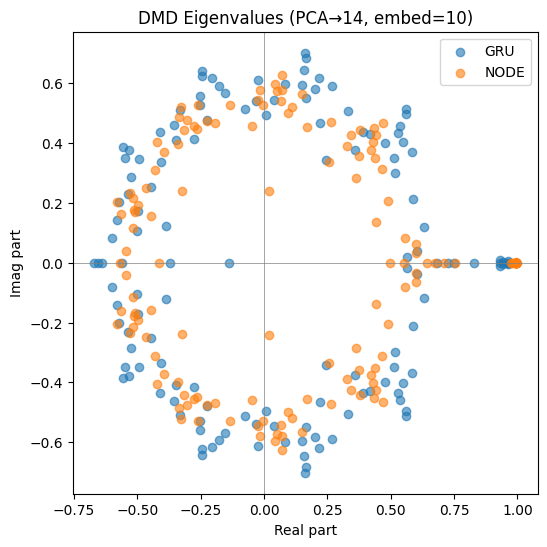

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 1) Flatten and assemble the full latent trajectories ---
h_src_np = latents_source.transpose(2, 0, 1).reshape(n_latent_source, -1).T
h_tgt_np = latents_targ.  transpose(2, 0, 1).reshape(n_latent_targ,   -1).T

# --- 2) PCA to common dimension k ---
k = min(n_latent_source, n_latent_targ)
pca_src = PCA(n_components=k).fit(h_src_np)
pca_tgt = PCA(n_components=k).fit(h_tgt_np)

h_src_k = torch.from_numpy(pca_src.transform(h_src_np)).float()  # (T_tot, k)
h_tgt_k = torch.from_numpy(pca_tgt.transform(h_tgt_np)).float()  # (T_tot, k)



embed_dim      = 10
delay_interval = 1

dsa = DSA(
    X=h_src_k,                # single tensor
    Y=h_tgt_k,                # single tensor
    n_delays=embed_dim,
    delay_interval=delay_interval,
    iters=500,
    score_method='euclidean',
    group='O(n)',
    device='cpu',
    verbose=False
)

# --- 4) Run DSA and get the distance ---
full_dsa_distance = dsa.fit_score()    # returns a scalar float
print(f"DSA distance (GRU vs NODE): {full_dsa_distance:.4f}")

# --- 5) Grab the two DMD objects from dsa.dmds ---
dmd_src = dsa.dmds[0][0]
dmd_tgt = dsa.dmds[1][0]

A_src = dmd_src.A_havok_dmd.detach().cpu().numpy()
A_tgt = dmd_tgt.A_havok_dmd.detach().cpu().numpy()

# --- 6) Plot DMD eigenvalue spectra ---
eig_src = np.linalg.eigvals(A_src)
eig_tgt = np.linalg.eigvals(A_tgt)

plt.figure(figsize=(6,6))
plt.scatter(eig_src.real, eig_src.imag, label='GRU', alpha=0.6)
plt.scatter(eig_tgt.real, eig_tgt.imag, label='NODE', alpha=0.6)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.title(f"DMD Eigenvalues (PCA→{k}, embed={embed_dim})")
plt.xlabel("Real part")
plt.ylabel("Imag part")
plt.show()



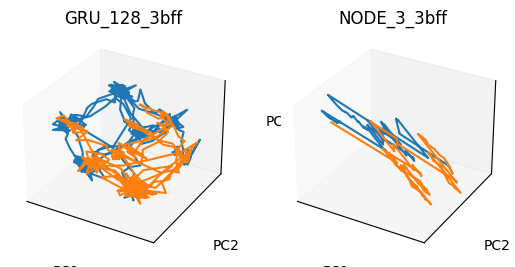

In [ ]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

# Section 4  (4-BFF)


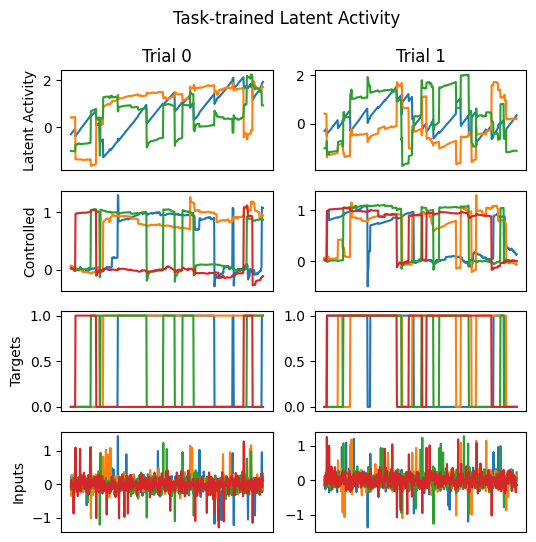

In [ ]:
from ctd.comparison.analysis.tt.tt import Analysis_TT
from ctd.task_modeling.model.node import NODE
fpath_NODE_4 = HOME_DIR + "models_NODE_4/"
# Create the analysis object:
analysis_NODE_4 = Analysis_TT(
    run_name = "NODE_3_4bff",
    filepath = fpath_NODE_4)

analysis_NODE_4.plot_trial_io(num_trials = 2)

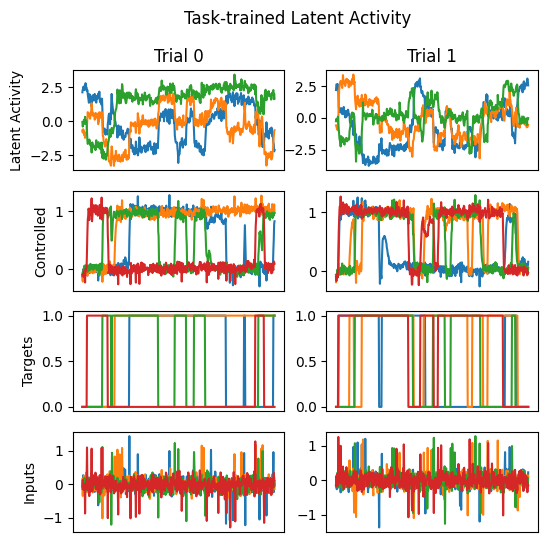

In [ ]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

fpath_GRU_128_4 = HOME_DIR + "models_GRU_4/"
# Create the analysis object:
analysis_GRU_128_4 = Analysis_TT(
    run_name = "GRU_128_4bff",
    filepath = fpath_GRU_128_4)

analysis_GRU_128_4.plot_trial_io(num_trials = 2)

In [ ]:
# NODE
print("NODE")

print(f"All data shape: {analysis_NODE_4.get_latents().shape}")
print(f"Train data shape: {analysis_NODE_4.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_NODE_4.get_latents(phase = 'val').shape}")

# GRU
print("GRU")
print(f"All data shape: {analysis_GRU_128_4.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128_4.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128_4.get_latents(phase = 'val').shape}")



NODE
All data shape: torch.Size([1000, 500, 29])
Train data shape: torch.Size([800, 500, 29])
Validation data shape: torch.Size([200, 500, 29])
GRU
All data shape: torch.Size([1000, 500, 128])
Train data shape: torch.Size([800, 500, 128])
Validation data shape: torch.Size([200, 500, 128])


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128_4
target = analysis_NODE_4

# Get the latent activity from the validation phase for each model:
latents_source_4 = source.get_latents(phase='train').detach().numpy()
latents_targ_4 = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source_4.shape
n_trials, n_timesteps, n_latent_targ = latents_targ_4.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source_4.shape}"
      f"\nLatent shape for target model: {latents_targ_4.shape}")

Latent shape for source model: (800, 500, 128)
Latent shape for target model: (800, 500, 29)


In [ ]:
# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source_4.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ_4.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [1.64894164e-01 8.69313121e-01 8.87548149e-01 8.13468933e-01
 8.66185546e-01 1.38321042e-01 8.07901621e-02 7.83187747e-02
 5.43487668e-02 7.99239278e-02 6.41188025e-02 1.08426511e-01
 4.00136113e-02 2.32747197e-02 3.23634744e-02 2.85726786e-02
 1.21368170e-02 1.48202777e-02 3.27966213e-02 5.36745787e-03
 6.52533770e-03 4.01556492e-03 1.85225606e-02 7.36320019e-03
 2.21090913e-02 7.34853745e-03 1.47984624e-02 8.41796398e-04
 1.30003095e-02]
Variance-weighted R2 of linear regression fit: 0.5976473093032837


**DSA by aitsam**

PCA(n_components=29)
PCA(n_components=29)
DSA distance between GRU and NODE: 12.2442


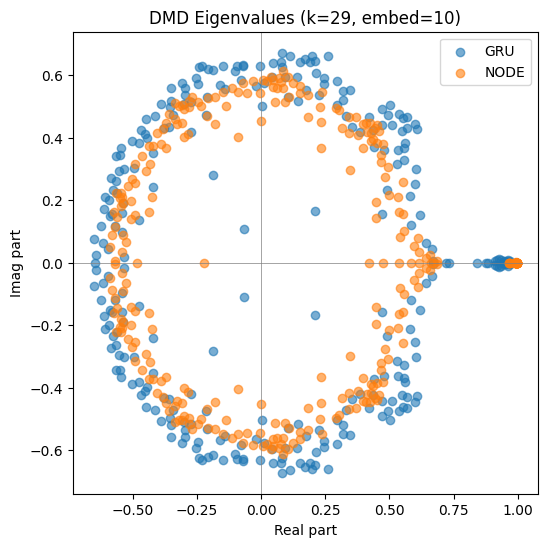

In [ ]:
# import numpy as np
# from scipy.linalg import svd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # 1) Concatenate all trials into shape (T_tot, D) for each model
# #    latents_source: (n_trials, n_timesteps, n_latent_source)
# #    latents_targ:   (n_trials, n_timesteps, n_latent_targ)
# h_src = latents_source_4.transpose(2, 0, 1).reshape(n_latent_source, -1).T  # → (T_tot, D_src)
# h_tgt = latents_targ_4.transpose(2, 0, 1).reshape(n_latent_targ,   -1).T  # → (T_tot, D_tgt)

# # 2) Choose common PCA dimension k (must be ≤ the smaller latent size)
# k = min(n_latent_source, n_latent_targ)

# # 3) Fit PCA separately and project
# pca_src = PCA(n_components=k).fit(h_src)
# pca_tgt = PCA(n_components=k).fit(h_tgt)

# print(pca_src)
# print(pca_tgt)

# h_src_k = pca_src.transform(h_src).T   # → (k, T_tot)
# h_tgt_k = pca_tgt.transform(h_tgt).T   # → (k, T_tot)


# # 4) Hankel (delay) embedding
# def hankel_embedding(h, d):
#     n, T = h.shape
#     K = T - d + 1
#     H = np.zeros((n * d, K), dtype=h.dtype)
#     for i in range(d):
#         H[i*n:(i+1)*n] = h[:, i:i+K]
#     return H

# embed_dim = 10  # or smaller if memory is tight
# H_src = hankel_embedding(h_src_k, embed_dim)
# H_tgt = hankel_embedding(h_tgt_k, embed_dim)

# # 5) Compute DMD (Koopman) matrices A
# def compute_dmd(H):
#     X, Y = H[:, :-1], H[:, 1:]
#     return Y @ np.linalg.pinv(X)

# A_src = compute_dmd(H_src)
# A_tgt = compute_dmd(H_tgt)

# # 6) Orthonormal‑Procrustes alignment & DSA distance
# def dsa_distance(A1, A2):
#     M = A1 @ A2.T
#     U, _, Vt = svd(M, full_matrices=False)
#     C = U @ Vt
#     dist = np.linalg.norm(A1 - C @ A2 @ C.T, ord='fro')
#     return dist, C

# distance, C_opt = dsa_distance(A_src, A_tgt)
# print(f"DSA distance between GRU and NODE: {distance:.4f}")

# # 7) Plot DMD eigenvalue spectra for intuition
# eig_src = np.linalg.eigvals(A_src)
# eig_tgt = np.linalg.eigvals(A_tgt)

# plt.figure(figsize=(6,6))
# plt.scatter(eig_src.real, eig_src.imag, label='GRU', alpha=0.6)
# plt.scatter(eig_tgt.real, eig_tgt.imag, label='NODE', alpha=0.6)
# plt.axhline(0, color='gray', linewidth=0.5)
# plt.axvline(0, color='gray', linewidth=0.5)
# plt.legend()
# plt.title(f"DMD Eigenvalues (k={k}, embed={embed_dim})")
# plt.xlabel("Real part")
# plt.ylabel("Imag part")
# plt.show()


**DSA by Functions**

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# --- 1) Flatten and assemble the full latent trajectories (as before) ---
# latents_source: (n_trials, n_timesteps, n_latent_source)
# latents_targ:   (n_trials, n_timesteps, n_latent_targ)

# Concatenate trials × time into one long time axis:
T_tot_src = n_trials * n_timesteps
T_tot_tgt = n_trials * n_timesteps  # should match for source/target

h_src_np = latents_source_4.transpose(2, 0, 1) \
                         .reshape(n_latent_source, -1) \
                         .T   # → (T_tot_src, D_src)
h_tgt_np = latents_targ_4.transpose(2, 0, 1) \
                         .reshape(n_latent_targ,   -1) \
                         .T   # → (T_tot_tgt, D_tgt)

# --- 2) Reduce both to the same k dimensions via PCA ---
k = min(n_latent_source, n_latent_targ)  # e.g. 14
print(k)
pca_src = PCA(n_components=k).fit(h_src_np)
pca_tgt = PCA(n_components=k).fit(h_tgt_np)

h_src_k_np = pca_src.transform(h_src_np)  # → (T_tot_src, k)
h_tgt_k_np = pca_tgt.transform(h_tgt_np)  # → (T_tot_tgt, k)

# --- 3) Convert to PyTorch tensors of shape (T, k) ---
h_src_k = torch.from_numpy(h_src_k_np).float()  # → (T_tot_src, k)
h_tgt_k = torch.from_numpy(h_tgt_k_np).float()  # → (T_tot_tgt, k)




# 1) Put your two trajectories into a Python list
models = [h_src_k, h_tgt_k]

# 2) Initialise DSA with your chosen delay parameters
embed_dim     = 10   # your hankel‐window length
delay_interval= 1    # usually 1 time‐step

dsa = DSA(
    X=models,
    n_delays=embed_dim,
    delay_interval=delay_interval,
    iters=500,
    score_method='euclidean',   # Frobenius‐norm alignment
    group='O(n)',               # orthonormal Procrustes
    device='cpu',
    verbose=True
)

# 3) Run the pairwise DSA
dist_matrix = dsa.fit_score()

# 4) Extract the distance between your two models
#    In a self‐pairwise setting, `dist_matrix` is a 2×2 matrix with zeros on the diagonal:
d_src_vs_tgt = dist_matrix[0,1]

print(f"DSA distance (GRU vs NODE): {d_src_vs_tgt:.4f}")


29
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 1 and 0
Finished optimizing C
Finished optimizing C
DSA distance (GRU vs NODE): 0.1226


**DSA function with plot**

DSA distance (GRU vs NODE): 0.1230


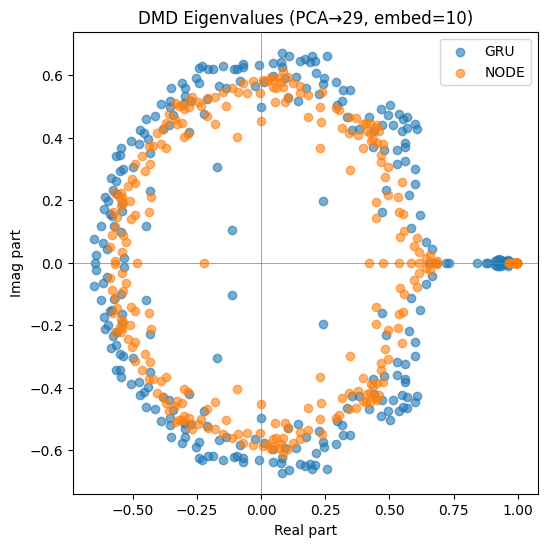

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 1) Flatten and assemble the full latent trajectories ---
h_src_np = latents_source_4.transpose(2, 0, 1).reshape(n_latent_source, -1).T
h_tgt_np = latents_targ_4.  transpose(2, 0, 1).reshape(n_latent_targ,   -1).T

# --- 2) PCA to common dimension k ---
k = min(n_latent_source, n_latent_targ)
pca_src = PCA(n_components=k).fit(h_src_np)
pca_tgt = PCA(n_components=k).fit(h_tgt_np)

h_src_k = torch.from_numpy(pca_src.transform(h_src_np)).float()  # (T_tot, k)
h_tgt_k = torch.from_numpy(pca_tgt.transform(h_tgt_np)).float()  # (T_tot, k)



embed_dim      = 10
delay_interval = 1

dsa = DSA(
    X=h_src_k,                # single tensor
    Y=h_tgt_k,                # single tensor
    n_delays=embed_dim,
    delay_interval=delay_interval,
    iters=500,
    score_method='euclidean',
    group='O(n)',
    device='cpu',
    verbose=False
)

# --- 4) Run DSA and get the distance ---
full_dsa_distance = dsa.fit_score()    # returns a scalar float
print(f"DSA distance (GRU vs NODE): {full_dsa_distance:.4f}")

# --- 5) Grab the two DMD objects from dsa.dmds ---
dmd_src = dsa.dmds[0][0]
dmd_tgt = dsa.dmds[1][0]

A_src = dmd_src.A_havok_dmd.detach().cpu().numpy()
A_tgt = dmd_tgt.A_havok_dmd.detach().cpu().numpy()

# --- 6) Plot DMD eigenvalue spectra ---
eig_src = np.linalg.eigvals(A_src)
eig_tgt = np.linalg.eigvals(A_tgt)

plt.figure(figsize=(6,6))
plt.scatter(eig_src.real, eig_src.imag, label='GRU', alpha=0.6)
plt.scatter(eig_tgt.real, eig_tgt.imag, label='NODE', alpha=0.6)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.title(f"DMD Eigenvalues (PCA→{k}, embed={embed_dim})")
plt.xlabel("Real part")
plt.ylabel("Imag part")
plt.show()



# END comparing GRU with NODE for 3BFF and 4BFF

# NEW EXAMPLE

## No_force field


### helper classes

In [ ]:
from motornet.environment import Environment
import gymnasium as gym
from gymnasium import spaces
from typing import Union, Optional, Any
from torch import Tensor
from numpy import ndarray
from ctd.task_modeling.task_env.loss_func import RandomTargetLoss

class RandomTarget_forcefield(Environment):
    """A reach to a random target from a random starting position with a delay period.

    Args:
        network: :class:`motornet.nets.layers.Network` object class or subclass.
        This is the network that will perform the task.

        name: `String`, the name of the task object instance.
        deriv_weight: `Float`, the weight of the muscle activation's derivative
        contribution to the default muscle L2 loss.

        force_field: 'np.array', the force field to apply to the effector, of same dimension as the skeleton space_dim. (2d in this case)
            example 1N force to the right: np.array([[1, 0]]).

        **kwargs: This is passed as-is to the parent :class:`Task` class.
    """

    def __init__(self, *args, **kwargs):
        #putting forcefield here so it isnt used as kwarg for parent class.
        self.force_field = kwargs.pop("force_field", np.array([[0, 0]]))
        print("force field is", self.force_field, flush=True)
        super().__init__(*args, **kwargs)

        self.obs_noise[: self.skeleton.space_dim] = [
            0.0
        ] * self.skeleton.space_dim  # target info is noiseless

        self.dataset_name = "RandomTarget"
        self.n_timesteps = np.floor(self.max_ep_duration / self.effector.dt).astype(int)
        self.input_labels = ["TargetX", "TargetY", "GoCue"] #recieves three input streams,
                                                            #target x and y specify desired location.
                                                            #go cue is a binary signal that indicates when the movement should start.
        self.output_labels = ["Pec", "Delt", "Brad", "TriLong", "Biceps", "TriLat"] #each muscle's activation is an output.
        self.context_inputs = spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32) #the three inputs, each range -2 to 2.
        self.coupled_env = True
        self.state_label = "fingertip"

        pos_weight = kwargs.get("pos_weight", 1.0) #i think this is for the position loss,
        act_weight = kwargs.get("act_weight", 1.0) #and for the activation loss.

        self.bump_mag_low = kwargs.get("bump_mag_low", 5)
        self.bump_mag_high = kwargs.get("bump_mag_high", 10)

        # self.force_field = kwargs.get("force_field", np.array([[0, 0]]))

        self.loss_func = RandomTargetLoss(
            position_loss=nn.MSELoss(), pos_weight=pos_weight, act_weight=act_weight
        )

    def step(self, action, deterministic=False, **kwargs):
        # Add the force field to any existing endpoint_load
        force_field_tensor = torch.tensor(self.force_field, dtype=torch.float32).to(self.device)

        if 'endpoint_load' in kwargs:
            kwargs['endpoint_load'] = kwargs['endpoint_load'] + force_field_tensor
        else:
            kwargs['endpoint_load'] = force_field_tensor

        return super().step(action, deterministic=deterministic, **kwargs)

    def generate_dataset(self, n_samples):
        # Make target circular, change loss function to be pinned at zero
        initial_state = []
        inputs = np.zeros((n_samples, self.n_timesteps, 3))

        goal_list = []
        go_cue_list = []
        target_on_list = []
        catch_trials = []
        ext_inputs_list = []

        for i in range(n_samples):
            catch_trial = np.random.choice([0, 1], p=[0.8, 0.2])
            bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])
            move_bump_trial = np.random.choice([0, 1], p=[0.5, 0.5])

            target_on = np.random.randint(10, 30)
            go_cue = np.random.randint(target_on, self.n_timesteps)
            if move_bump_trial:
                bump_time = np.random.randint(go_cue, go_cue + 40)
            else:
                bump_time = np.random.randint(0, self.n_timesteps - 30)
            bump_duration = np.random.randint(15, 30)
            bump_theta = np.random.uniform(0, 2 * np.pi)
            bump_mag = np.random.uniform(self.bump_mag_low, self.bump_mag_high)

            target_on_list.append(target_on)

            info = self.generate_trial_info()
            initial_state.append(info["ics_joint"])
            initial_state_xy = info["ics_xy"]


            #this is the environmental force field input. leave it set to zero for now so we can add the bump first.
            env_inputs_mat = np.zeros((self.n_timesteps, 2))

            #then it has the bump added.
            if bump_trial:
                bump_end = min(bump_time + bump_duration, self.n_timesteps)
                env_inputs_mat[bump_time:bump_end, :] = np.array(
                    [bump_mag * np.cos(bump_theta), bump_mag * np.sin(bump_theta)]
                )

            #we add the force field here, so it can then get loaded into the input_env as normal.
            env_inputs_mat += self.force_field[0,:]

            goal_matrix = torch.zeros((self.n_timesteps, self.skeleton.space_dim))
            if catch_trial:
                go_cue = -1
                goal_matrix[:, :] = initial_state_xy
            else:
                inputs[i, go_cue:, 2] = 1

                goal_matrix[:go_cue, :] = initial_state_xy
                goal_matrix[go_cue:, :] = torch.squeeze(info["goal"])

            go_cue_list.append(go_cue)
            inputs[i, target_on:, 0:2] = info["goal"]

            catch_trials.append(catch_trial)
            goal_list.append(goal_matrix)
            ext_inputs_list.append(env_inputs_mat)

        go_cue_list = np.array(go_cue_list)
        target_on_list = np.array(target_on_list)
        env_inputs = np.stack(ext_inputs_list, axis=0)
        extra = np.stack((target_on_list, go_cue_list), axis=1)
        conds = np.array(catch_trials)

        initial_state = torch.stack(initial_state, axis=0)
        goal_list = torch.stack(goal_list, axis=0)
        dataset_dict = {
            "ics": initial_state,
            "inputs": inputs,
            "inputs_to_env": env_inputs,
            "targets": goal_list,
            "conds": conds,
            "extra": extra,
            "true_inputs": inputs,
        }
        extra_dict = {}
        return dataset_dict, extra_dict

    def generate_trial_info(self):
        """
        Generate a trial for the task.
        This is a reach to a random target from a random starting
        position with a delay period.
        """
        sho_limit = [-90, 180]#[0, 135]  # mechanical constraints - used to be -90 180
        elb_limit = [-90, 180]#[0, 155]
        sho_ang = np.deg2rad(np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30))
        elb_ang = np.deg2rad(np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30))

        sho_ang_targ = np.deg2rad(
            np.random.uniform(sho_limit[0] + 30, sho_limit[1] - 30)
        )
        elb_ang_targ = np.deg2rad(
            np.random.uniform(elb_limit[0] + 30, elb_limit[1] - 30)
        )

        angs = torch.tensor(np.array([sho_ang, elb_ang, 0, 0]))
        ang_targ = torch.tensor(np.array([sho_ang_targ, elb_ang_targ, 0, 0]))

        target_pos = self.joint2cartesian(
            torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        start_xy = self.joint2cartesian(
            torch.tensor(angs, dtype=torch.float32, device=self.device)
        ).chunk(2, dim=-1)[0]

        info = dict(
            ics_joint=angs,
            ics_xy=start_xy,
            goal=target_pos,
        )
        return info

    def set_goal(
        self,
        goal: torch.Tensor,
    ):
        """
        Sets the goal of the task. This is the target position of the effector.
        """
        self.goal = goal

    def get_obs(self, action=None, deterministic: bool = False) -> Union[Tensor, ndarray]:
        self.update_obs_buffer(action=action)

        obs_as_list = [
            self.obs_buffer["vision"][0],
            self.obs_buffer["proprioception"][0],
        ] + self.obs_buffer["action"][: self.action_frame_stacking]

        obs = torch.cat(obs_as_list, dim=-1)

        if deterministic is False:
            obs = self.apply_noise(obs, noise=self.obs_noise)

        return obs if self.differentiable else self.detach(obs)

    def reset(
        self,
        batch_size: int = 1,
        options: Optional[dict[str, Any]] = None,
        seed: Optional[int] = None,
    ) -> tuple[Any, dict[str, Any]]:

        """
        Uses the :meth:`Environment.reset()` method of the parent class
        :class:`Environment` that can be overwritten to change the returned data.
        Here the goals (`i.e.`, the targets) are drawn from a random uniform
        distribution across the full joint space.
        """
        sho_limit = np.deg2rad([0, 135])  # mechanical constraints - used to be -90 180
        elb_limit = np.deg2rad([0, 155])
        # Make self.obs_noise a list
        self._set_generator(seed=seed)
        # if ic_state is in options, use that
        if options is not None and "deterministic" in options.keys():
            deterministic = options["deterministic"]
        else:
            deterministic = False
        if options is not None and "ic_state" in options.keys():
            ic_state_shape = np.shape(self.detach(options["ic_state"]))
            if ic_state_shape[0] > 1:
                batch_size = ic_state_shape[0]
            ic_state = options["ic_state"]
        else:
            ic_state = self.q_init

        if options is not None and "target_state" in options.keys():
            self.goal = options["target_state"]
        else:
            sho_ang = np.random.uniform(
                sho_limit[0] + 20, sho_limit[1] - 20, size=batch_size
            )
            elb_ang = np.random.uniform(
                elb_limit[0] + 20, elb_limit[1] - 20, size=batch_size
            )
            sho_vel = np.zeros(batch_size)
            elb_vel = np.zeros(batch_size)
            angs = np.stack((sho_ang, elb_ang, sho_vel, elb_vel), axis=1)
            self.goal = self.joint2cartesian(
                torch.tensor(angs, dtype=torch.float32, device=self.device)
            ).chunk(2, dim=-1)[0]

        options = {
            "batch_size": batch_size,
            "joint_state": ic_state,
        }
        self.effector.reset(options=options)

        self.elapsed = 0.0

        action = torch.zeros((batch_size, self.action_space.shape[0])).to(self.device)

        self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(
            self.obs_buffer["proprioception"]
        )
        self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
        self.obs_buffer["action"] = [action] * self.action_frame_stacking

        action = action if self.differentiable else self.detach(action)

        obs = self.get_obs(deterministic=deterministic)
        info = {
            "states": self._maybe_detach_states(),
            "action": action,
            "noisy action": action,
            "goal": self.goal if self.differentiable else self.detach(self.goal),
        }
        return obs, info


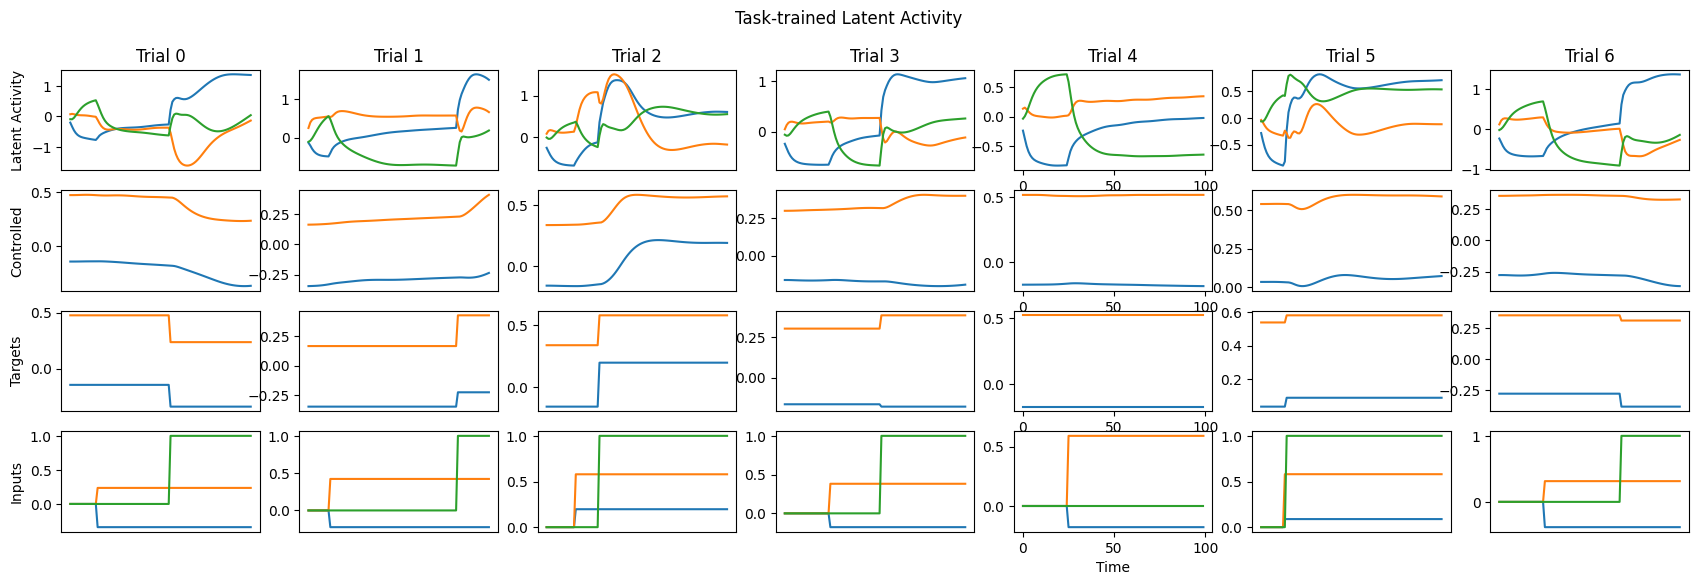

In [ ]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128_NF = HOME_DIR + "NO_forcefield/"
# Create the analysis object:
analysis_GRU_128_noforce = TT_RandomTarget(
    run_name = "GRU_128_nof",
    filepath = fpath_GRU_128_NF)

analysis_GRU_128_noforce.plot_trial_io(num_trials = 7)

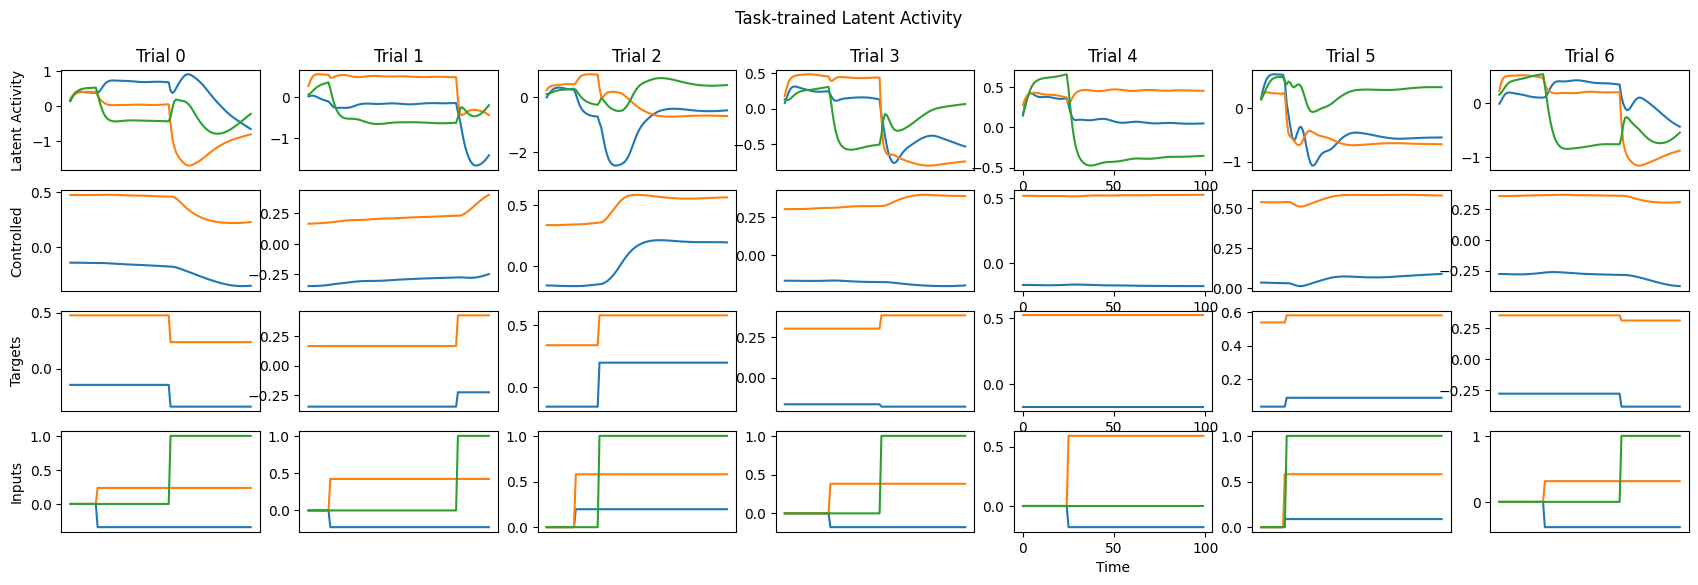

In [ ]:

from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128_FF = HOME_DIR + "forcefield/"

# Create the analysis object:
analysis_GRU_128_forcefield = TT_RandomTarget(
    run_name = "GRU_128_ff",
    filepath = fpath_GRU_128_FF)

analysis_GRU_128_forcefield.plot_trial_io(num_trials = 7)

In [ ]:
# NODE
print("No Forcefield")

print(f"All data shape: {analysis_GRU_128_noforce.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128_noforce.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128_noforce.get_latents(phase = 'val').shape}")

# GRU
print("Forcefield")
print(f"All data shape: {analysis_GRU_128_forcefield.get_latents().shape}")
print(f"Train data shape: {analysis_GRU_128_forcefield.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_GRU_128_forcefield.get_latents(phase = 'val').shape}")

No Forcefield
All data shape: torch.Size([1000, 100, 128])
Train data shape: torch.Size([800, 100, 128])
Validation data shape: torch.Size([200, 100, 128])
Forcefield
All data shape: torch.Size([1000, 100, 128])
Train data shape: torch.Size([800, 100, 128])
Validation data shape: torch.Size([200, 100, 128])


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128_noforce
target = analysis_GRU_128_forcefield

# Get the latent activity from the validation phase for each model:
latents_source_nf = source.get_latents(phase='train').detach().numpy()
latents_targ_ff = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source_4.shape
n_trials, n_timesteps, n_latent_targ = latents_targ_4.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source_nf.shape}"
      f"\nLatent shape for target model: {latents_targ_ff.shape}")

NameError: name 'latents_source_4' is not defined

In [ ]:
# # Perform PCA on both latent spaces to find axes of highest variance
# pca_source = PCA()
# pca_targ = PCA()
# lats_source_pca = pca_source.fit_transform(latents_source_nf.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
# lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

# lats_targ_pca = pca_targ.fit_transform(latents_targ_ff.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
# lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# # Fit a linear regression model to predict the target latents from the source latents
# reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# # Get the R2 of the fit
# preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
# r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
# r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
# print(f"R2 of linear regression fit: {r2s}")
# print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

ValueError: cannot reshape array of size 10240000 into shape (800,500,newaxis)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# --- pull the true shapes straight from your data ---
n_trials_src, n_timesteps_src, n_latent_src = latents_source_nf.shape
n_trials_val, n_timesteps_val, _            = latents_source_val.shape
n_trials_tgt, n_timesteps_tgt, n_latent_tgt = latents_targ_ff.shape
_,         _,             n_latent_tgt_val = latents_targ_val.shape

# --- flatten each (trials × timesteps) into rows for PCA/training ---
X_src_train = latents_source_nf.reshape(-1, n_latent_src)       # shape (n_trials_src*n_timesteps_src, n_latent_src)
X_src_val   = latents_source_val.reshape(-1,   n_latent_src)    # shape (n_trials_val  *n_timesteps_val,   n_latent_src)

X_tgt_train = latents_targ_ff.reshape(-1, n_latent_tgt)         # likewise for target
X_tgt_val   = latents_targ_val.reshape(-1, n_latent_tgt_val)

# --- fit PCA on the *training* data, then transform both train & val ---
pca_src = PCA().fit(X_src_train)
pca_tgt = PCA().fit(X_tgt_train)

X_src_train_pca = pca_src.transform(X_src_train)
X_src_val_pca   = pca_src.transform(X_src_val)

X_tgt_train_pca = pca_tgt.transform(X_tgt_train)
X_tgt_val_pca   = pca_tgt.transform(X_tgt_val)

# --- reshape back into (trials, timesteps, n_components) ---
lats_src_pca     = X_src_train_pca.reshape(n_trials_src, n_timesteps_src, -1)
lats_src_pca_val = X_src_val_pca  .reshape(n_trials_val,   n_timesteps_val,   -1)

lats_tgt_pca     = X_tgt_train_pca.reshape(n_trials_tgt, n_timesteps_tgt, -1)
lats_tgt_pca_val = X_tgt_val_pca  .reshape(n_trials_val, n_timesteps_val,   -1)

# --- get the new latent dims after PCA ---
d_src = lats_src_pca.shape[2]
d_tgt = lats_tgt_pca.shape[2]

# --- linear regression on the *training* PCs ---
reg = LinearRegression().fit(
    lats_src_pca.reshape(-1, d_src),
    lats_tgt_pca.reshape(-1, d_tgt)
)

# --- predict on *validation* PCs and compute R² ---
preds = reg.predict(lats_src_pca_val.reshape(-1, d_src))
r2s     = r2_score(
    lats_tgt_pca_val.reshape(-1, d_tgt),
    preds,
    multioutput="raw_values"
)
r2_var  = r2_score(
    lats_tgt_pca_val.reshape(-1, d_tgt),
    preds,
    multioutput="variance_weighted"
)

print(f"Per‑component R²:             {r2s}")
print(f"Variance‑weighted R² (scalar): {r2_var:.4f}")


Per‑component R²:             [0.9972515  0.9983988  0.99128866 0.9944962  0.9791384  0.9868396
 0.9767229  0.9708828  0.9770581  0.9486202  0.90883255 0.9536708
 0.9360874  0.9277428  0.9165232  0.92065996 0.92265177 0.9234151
 0.90044606 0.87517864 0.8956995  0.82092196 0.8942358  0.8035928
 0.8021092  0.8446052  0.7344768  0.7650616  0.81174946 0.7013874
 0.791011   0.6366687  0.601362   0.6205732  0.6199992  0.6389733
 0.5831785  0.5500372  0.53785276 0.4499349  0.5316235  0.44624466
 0.51421845 0.47980905 0.46739155 0.42366683 0.4401635  0.42452085
 0.23140955 0.30903798 0.32805985 0.21201754 0.41924983 0.39928496
 0.36266172 0.29640257 0.28998417 0.20296419 0.271061   0.12437797
 0.43770635 0.2069155  0.13255948 0.19209176 0.23147923 0.20700592
 0.1433149  0.17929935 0.23965484 0.13890457 0.17296094 0.20364201
 0.12201238 0.09676629 0.12768108 0.08955348 0.12336677 0.08392268
 0.05147845 0.06091154 0.07158238 0.08025289 0.09322006 0.09000981
 0.06265807 0.0776909  0.11388248 0.07

**DSA with functions and plot**

Full‑surrogate DSA distance: 0.1387


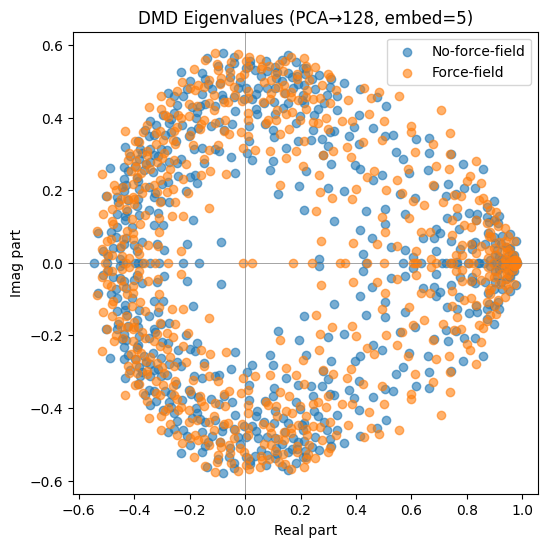

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from DSA_main import DSA    # adjust to your import path

# 1) Get the true shapes from your data
n_trials_src, n_timesteps_src, n_latent_src = latents_source_nf.shape
n_trials_tgt, n_timesteps_tgt, n_latent_tgt = latents_targ_ff.shape

# 2) Flatten (trials × timesteps) → rows for PCA
X_src = latents_source_nf.reshape(-1, n_latent_src)  # (n_trials_src*n_timesteps_src, n_latent_src)
X_tgt = latents_targ_ff   .reshape(-1, n_latent_tgt)  # (n_trials_tgt*n_timesteps_tgt, n_latent_tgt)

# 3) PCA to common dimension k
k = min(n_latent_src, n_latent_tgt)
pca_src = PCA(n_components=k).fit(X_src)
pca_tgt = PCA(n_components=k).fit(X_tgt)

# 4) Project & convert to torch (shape: (T_tot, k))
h_src_k = torch.from_numpy(pca_src.transform(X_src)).float()
h_tgt_k = torch.from_numpy(pca_tgt.transform(X_tgt)).float()

# 5) Set up and run DSA
embed_dim      = 5
delay_interval = 1

dsa = DSA(
    X=h_src_k,
    Y=h_tgt_k,
    n_delays=embed_dim,
    delay_interval=delay_interval,
    iters=500,
    score_method='euclidean',
    group='O(n)',
    device='cpu',
    verbose=False
)

full_dsa_distance = dsa.fit_score()  # scalar
print(f"Full‑surrogate DSA distance: {full_dsa_distance:.4f}")

# 6) Extract the learned Koopman surrogates
dmd_src = dsa.dmds[0][0]
dmd_tgt = dsa.dmds[1][0]

A_src = dmd_src.A_havok_dmd.detach().cpu().numpy()
A_tgt = dmd_tgt.A_havok_dmd.detach().cpu().numpy()

# 7) Plot DMD eigenvalue spectra
eig_src = np.linalg.eigvals(A_src)
eig_tgt = np.linalg.eigvals(A_tgt)

plt.figure(figsize=(6,6))
plt.scatter(eig_src.real, eig_src.imag, label='No‑force‑field', alpha=0.6)
plt.scatter(eig_tgt.real, eig_tgt.imag, label='Force‑field',     alpha=0.6)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.title(f"DMD Eigenvalues (PCA→{k}, embed={embed_dim})")
plt.xlabel("Real part")
plt.ylabel("Imag part")
plt.show()


## Section 6: Introducing the Random Target task

Now that we've developed intuition on a simple, well-understood task, let's move up the ladder of complexity!

The second task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a package developed by [Oli Codol et al.](https://github.com/OlivierCodol/MotorNet) that provides environments for training RNNs to control biomechanical models!

Here is a short clip of what this task looks like when performed by a well-trained model:

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/FinalGif.gif?raw=true" width="300"/>


Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial

The model is trained to:
1. Minimize the MSE between the hand position and the desired hand position
2. Minimize the squared muscle activation

with each loss term being weighted by a scalar.

In [ ]:
from ctd.task_modeling.task_env.task_env import RandomTarget
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
# Create the analysis object:
rt_task_env = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))

⏳⏳⏳

Now, to train the model! We use the same procedure as the 3BFF above; however, this model will take a bit longer to train, as of the serial nature of this task, the parallelization allowed by GPUs doesn't help speed up our training!

⏳⏳⏳

In [ ]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes
rnn.init_model(
    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# # Step 7: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
# trainer = Trainer(accelerator= "cpu",max_epochs=500,enable_progress_bar=False)

# # Step 8: Fit the model
# trainer.fit(task_wrapper, task_datamodule)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001

Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetIllustration-01.png?raw=true" width="400"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetGif.gif?raw=true" width="300"/>

In the later questions, we will ask you to modify the environments in MotorNet to test how well your models can generalize to new tasks!

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introducing_the_random_target_task")

---
## Conclusion

That's it!

To recap, in this tutorial, we learned:
1. The basics of two tasks, the Three-Bit Flip-Flop and the Random Target task.
2. How to train recurrent neural network models on these tasks
3. Methods of visualizing and quantifying differences between these task-trained models.

As you begin to extend beyond this tutorial, you will likely need to make your own environments, or modify existing environments to test the ability of models to generalize. We've tried to document the code-base to make this as easy as possible, but feel free to reach out if you have any questions!

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusion")